# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import anndata as ad
import random
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from scarches.models.scpoli import scPoli

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:[rank: 0] Global seed set to 0


In [3]:
condition_key = 'species'
cell_type_key = ['Subclass']
target_species = ['human']

SOURCE_DATA_FILENAME = os.path.expanduser('~/data/treeArches/M1_counts_reference.h5ad')
TARGET_DATA_FILENAME = os.path.expanduser('~/data/treeArches/M1_counts_query.h5ad')

Path(os.path.expanduser("~/io/scpoli_repr/scpoli_models/")).mkdir(parents=True, exist_ok=True)
OUTPUT_format = os.path.expanduser("~/io/scpoli_repr/scpoli_models/M1_cross_species_run1_{ext}")

In [4]:
PARAMS = {
    'EPOCHS': 50,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 40,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    #'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    #'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_prototype_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 50,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 4,
    'ETA': 1,
}

MAPPING_PARAMS = {
    'EPOCHS': 50,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 40,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    #'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    #'DATA': 'pancreas',                                #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_prototype_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 50,
    'ALPHA_EPOCH_ANNEAL': 1e3,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 4,
    'ETA': 1,
}

In [5]:
source_adata = sc.read(SOURCE_DATA_FILENAME)
target_adata = sc.read(TARGET_DATA_FILENAME)
print(source_adata)
print(target_adata)

AnnData object with n_obs × n_vars = 229017 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
AnnData object with n_obs × n_vars = 76621 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'


In [6]:
model_output_path = OUTPUT_format.format(ext="")
latent_output_path = OUTPUT_format.format(ext=".latent.h5ad")

# Reference Building

In [8]:
scpoli_model = scPoli(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[64, 64],
    latent_dim=PARAMS['LATENT_DIM'],
    embedding_dim=20,
    inject_condition=['encoder', 'decoder']
)

scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=45,
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
    use_stratified_sampling=False,
    best_reload=False
)
scpoli_model.save(model_output_path, overwrite=True)

data_latent = scpoli_model.get_latent(
    source_adata.X.A.astype('float32'), 
    source_adata.obs[condition_key].values,
    mean=True,
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = source_adata.obs.copy()
adata_latent.write(latent_output_path)

Embedding dictionary:
 	Num conditions: 2
 	Embedding dim: 20
Encoder Architecture:
	Input Layer in, out and cond: 2000 64 20
	Hidden Layer 1 in/out: 64 64
	Mean/Var Layer in/out: 64 25
Decoder Architecture:
	First Layer in, out and cond:  25 64 20
	Hidden Layer 1 in/out: 64 64
	Output Layer in/out:  64 2000 

Initializing dataloaders
Starting training
 |████████████████████| 100.0%  - val_loss: 1066.2615666736 - val_cvae_loss: 1053.6624397832 - val_prototype_loss: 12.5991269277 - val_labeled_loss: 12.5991269277


# Query to reference mapping

In [17]:
transfer_model = scPoli.load_query_data(
    adata=target_adata, 
    reference_model=model_output_path,
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 76621 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features'
Embedding dictionary:
 	Num conditions: 3
 	Embedding dim: 20
Encoder Architecture:
	Input Layer in, out and cond: 2000 64 20
	Hidden Layer 1 in/out: 64 64
	Mean/Var Layer in/out: 64 25
Decoder Architecture:
	First Layer in, out and cond:  25 64 20
	Hidden Layer 1 in/out: 64 64
	Output Layer in/out:  64 2000 



In [21]:
transfer_model.train(
    n_epochs=100,
    pretraining_epochs=80,
    early_stopping_kwargs=MAPPING_PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=MAPPING_PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=0,
    clustering_res=MAPPING_PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=MAPPING_PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=MAPPING_PARAMS['UNLABELED_LOSS_METRIC'],
    weight_decay=0,
    use_stratified_sampling=False,
    reload_best=False,
)

The missing labels are: {''}
Therefore integer value of those labels is set to -1
The missing labels are: {''}
Therefore integer value of those labels is set to -1
The missing labels are: {''}
Therefore integer value of those labels is set to -1
The missing labels are: {''}
Therefore integer value of those labels is set to -1
Initializing dataloaders
Starting training
 |████████████████----| 80.0%  - val_loss: 1490.3438171387 - val_cvae_loss: 1490.3438171387
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Clustering succesful. Found 23 clusters.
 |████████████████████| 100.0%  - val_loss: 1490.9037516276 - val_cvae_loss: 1490.9037516276 - val_prototype_loss: 0.0000000000 - val_unlabeled_loss: 0.9307438572


In [34]:
latent_query = sc.AnnData(transfer_model.get_latent(
    target_adata.X.A, 
    target_adata.obs[condition_key]
), obs=target_adata.obs.copy())

query_predictions = transfer_model.classify(
    x=target_adata.X.A,
    c=target_adata.obs[condition_key],
    get_prob=False,
)
latent_query.obs['pred_subclass'] = query_predictions['Subclass']['preds']

In [35]:
latent_query.write(OUTPUT_format.format(ext=".query.latent.h5ad"))

# Analysis

In [10]:
# Load
scpoli_model = scPoli.load(model_output_path, source_adata)
adata_latent = sc.read(latent_output_path)
latent_query = sc.read(OUTPUT_format.format(ext=".query.latent.h5ad"))

AnnData object with n_obs × n_vars = 229017 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Class', 'Subclass', 'RNA_cluster', 'Cross_species', 'species'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
Embedding dictionary:
 	Num conditions: 2
 	Embedding dim: 20
Encoder Architecture:
	Input Layer in, out and cond: 2000 64 20
	Hidden Layer 1 in/out: 64 64
	Mean/Var Layer in/out: 64 25
Decoder Architecture:
	First Layer in, out and cond:  25 64 20
	Hidden Layer 1 in/out: 64 64
	Output Layer in/out:  64 2000 

Only considering the two last: ['.latent', '.h5ad'].
Only considering the two last: ['.latent', '.h5ad'].


In [40]:
def plot_classification_results(adata_obs, annotation_col, result_col):
    ct_ordered = list(sorted(adata_obs[annotation_col].unique()))
    plot_df = adata_obs[[annotation_col, result_col]].copy()
    
    plot_df['Annotations'] = plot_df[annotation_col]
    plot_df['status'] = plot_df[result_col].map({'Correct': 'Correct', 'Incorrect': 'Incorrect'})
    
    total_n_per_ct = plot_df['Annotations'].value_counts()
    total_n_per_ct["Overall"] = plot_df.shape[0]

    perc_correct = (pd.crosstab(plot_df['Annotations'], plot_df['status']).loc[ct_ordered, :])
    perc_correct.loc["Overall", :] = (
        plot_df['status'].value_counts() / total_n_per_ct["Overall"] * 100
    )
    perc_correct = perc_correct.div(perc_correct.sum(axis=1), axis="rows") * 100
    
    with plt.rc_context(
        {
            "figure.figsize": (0.4 * len(perc_correct), 3),
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        perc_correct.plot(kind="bar", stacked=True, ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        
        ax.legend(handles[::-1], labels[::-1], loc=(1.01, 0.60), frameon=False)

        plt.xticks(
            ticks=range(len(ct_ordered) + 1),
            labels=[f"{ct} ({total_n_per_ct[ct]})" for ct in ct_ordered + ["Overall"]],
        )
        ax.set_ylabel("% of cells")
        plt.grid(False)
        plt.show()

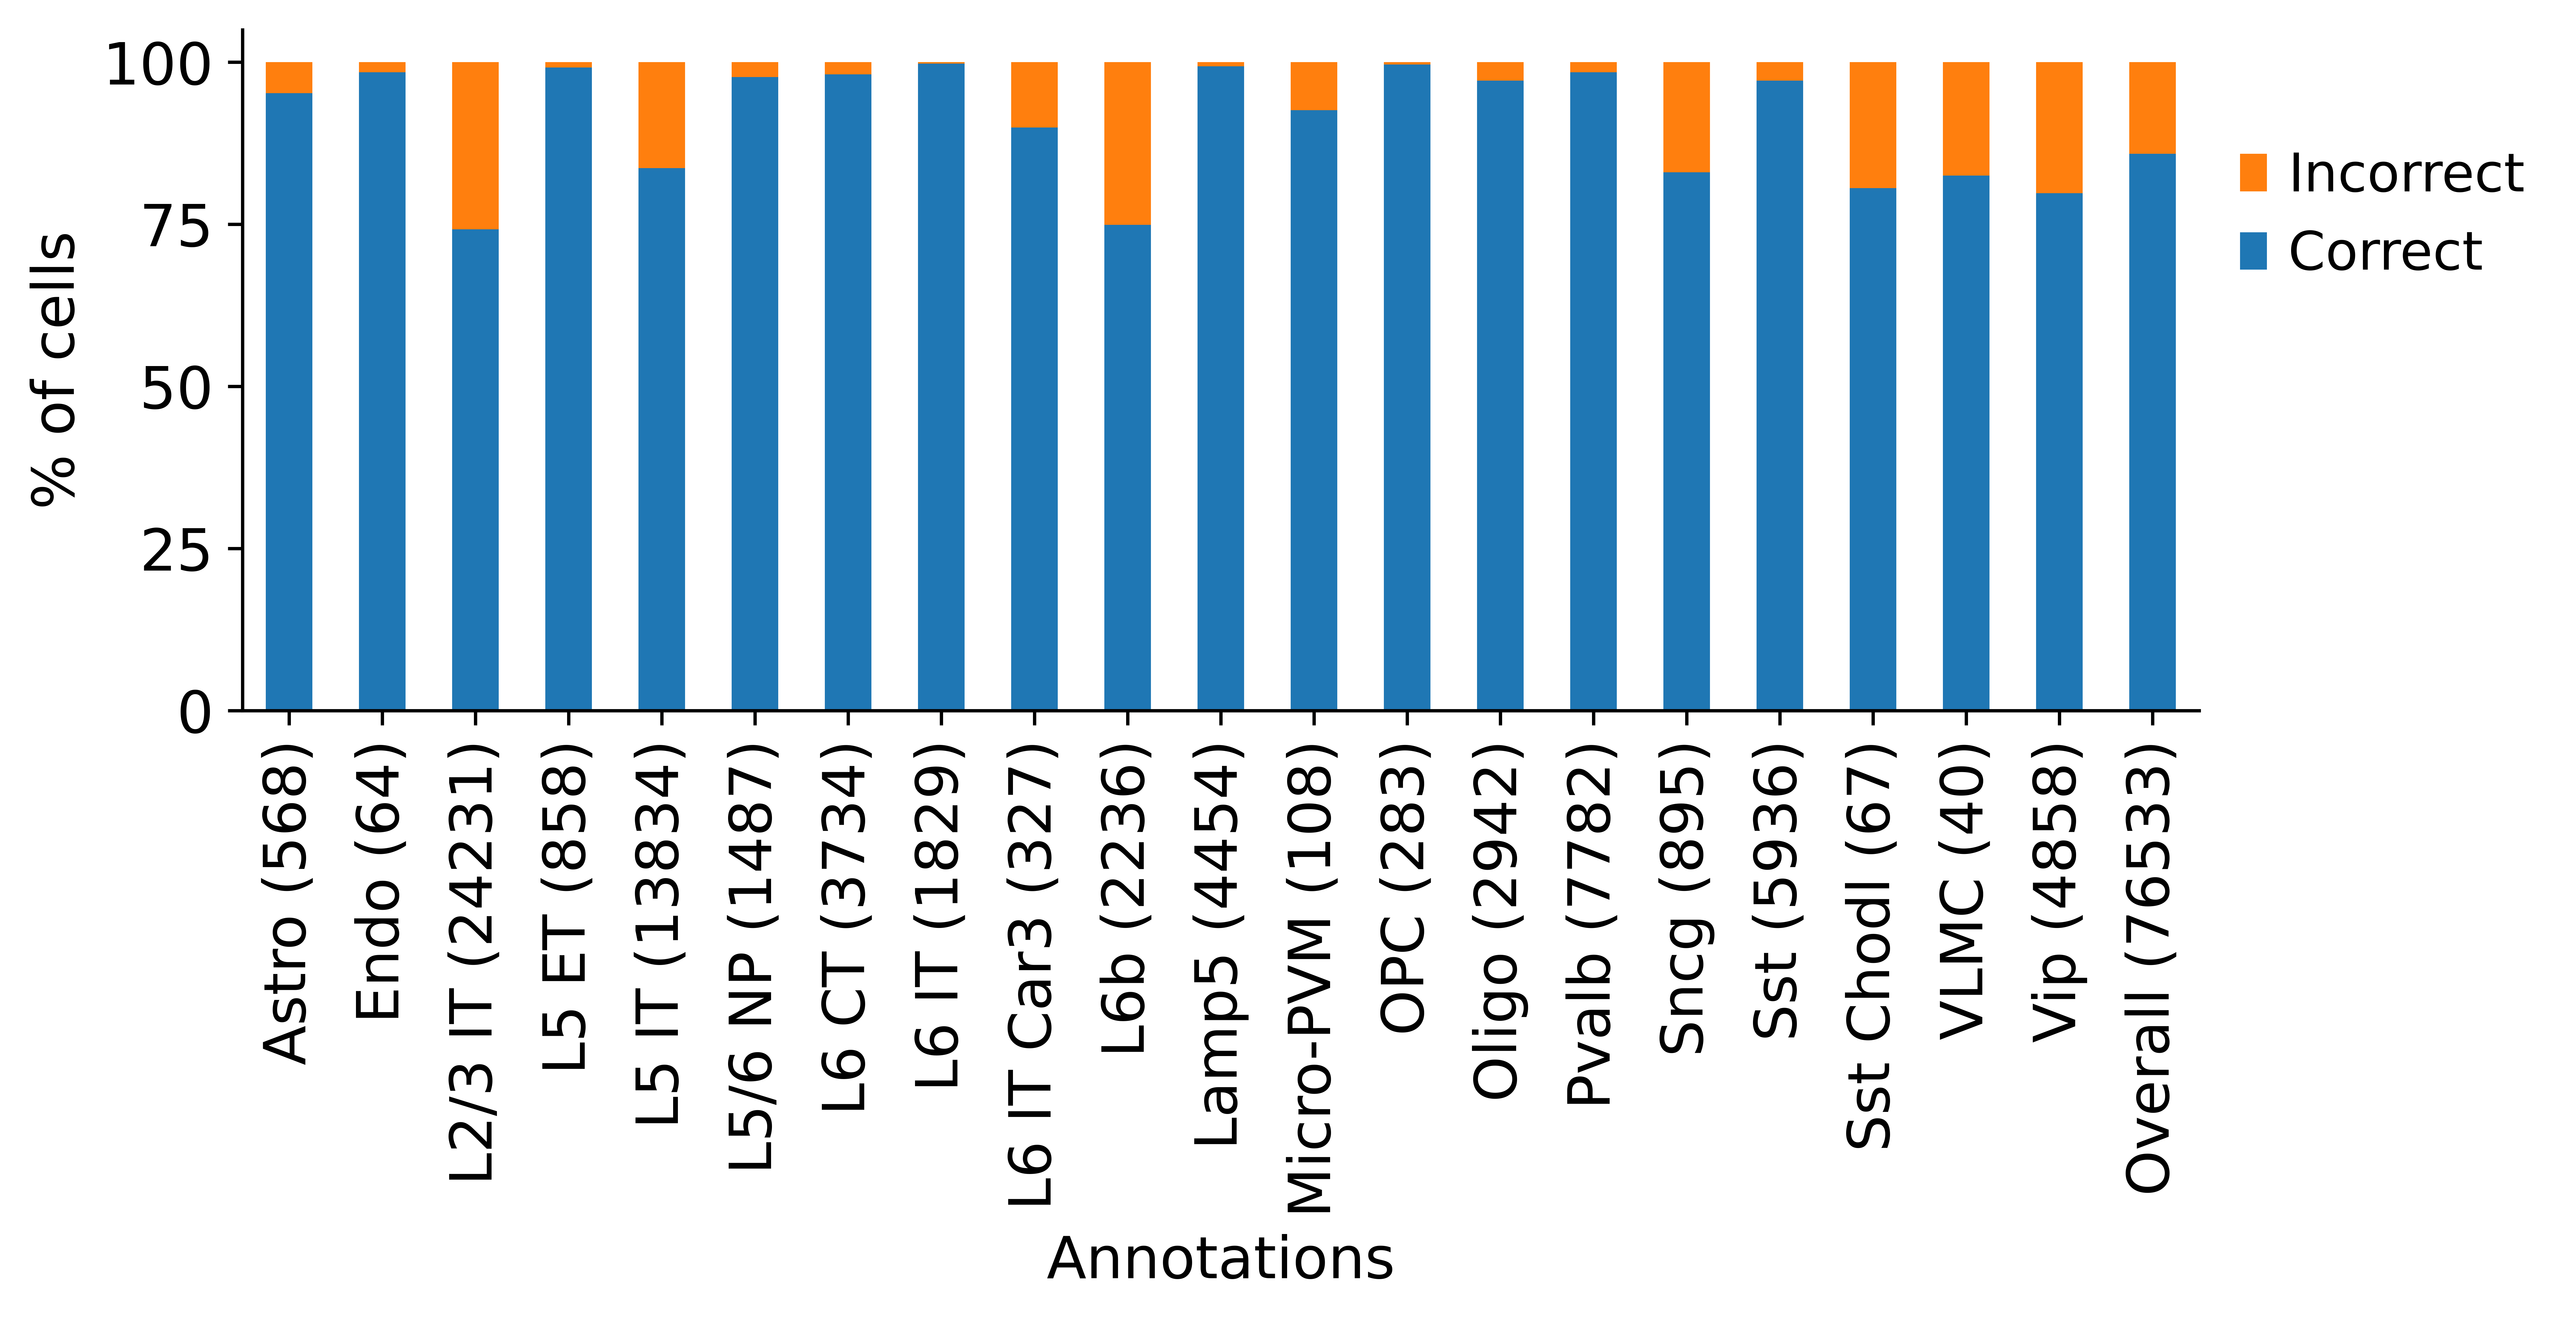

In [54]:
df = pd.DataFrame({'true': latent_query.obs['Subclass'].astype(str), 'pred': latent_query.obs['pred_subclass'].astype(str)})
df = df[df['true'] != ''].copy()
df['result'] = np.where(df['pred'] == df['true'], 'Correct', 'Incorrect')
classification_results = df.copy()

plot_classification_results(df, 'true', 'result')

In [55]:
adata_latent_subsampled.write(os.path.expanduser('~/tmp/scpoli_m1_ref.h5ad'))
adata_latent_q_subsampled.write(os.path.expanduser('~/tmp/scpoli_m1_q.h5ad'))
classification_results.to_csv(os.path.expanduser('~/tmp/scpoli_m1_classification_results.h5ad'))